# Calculate Dimensionality of Data

In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from multiprocessing import Process, Manager, Pool

sns.set(style="white", palette="dark", color_codes=True)

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()

In [2]:
def get_pca_dimensionality(array, cutoff):
    """ 
    Returns the dimensionality of the given array, defined as the number of PCA components needed to exceed
    the cutoff of cumulative variance explained.
    
    Note: This calculates all components, assuming components number should be 
    
    """
    
    data_pca = PCA(n_components = array.shape[0]).fit(array)
    cum_var_explained = np.cumsum(data_pca.explained_variance_)/np.sum(data_pca.explained_variance_)
    dimensionality = np.where(cum_var_explained > cutoff)[0][0]
    return dimensionality

100%|██████████| 8/8 [4:01:39<00:00, 1903.32s/it]  


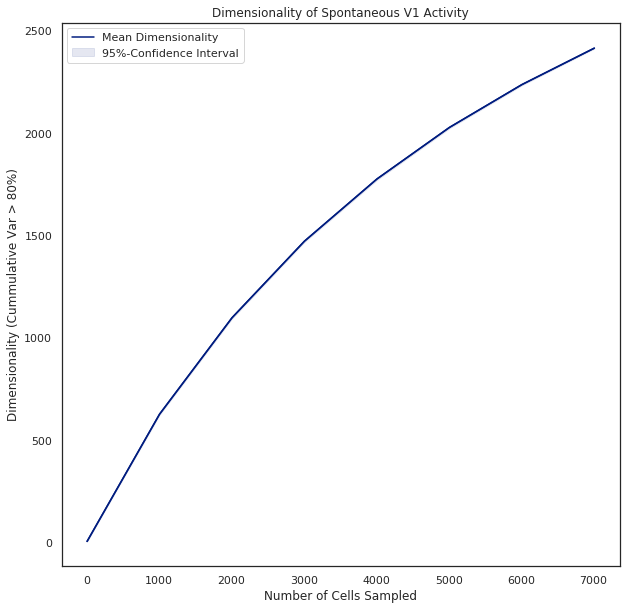

In [7]:
# SETTINGS
cum_var_cutoff = 0.8
pca_repetitions = 100
cell_sample_nums = np.arange(10,7011, 1000)  # Array of number of cells to sample
np.random.shuffle(cell_sample_nums)  # This is shuffled to better estimate runtime in TQDM

# Create empty arrays to store values
dimensionality_means = np.zeros_like(cell_sample_nums, dtype='float')
dimensionality_lower_ci = np.zeros_like(cell_sample_nums)  # 5th percentile of bootstrapped dimensionality
dimensionality_upper_ci = np.zeros_like(cell_sample_nums)  # 95th percentile of bootstrapped dimensionality

# Transform data to z-score to center it as the units are not the same for all neurons
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)

for i,cell_sample_num in tqdm(enumerate(cell_sample_nums), total=len(cell_sample_nums)):  
    
    # Create list of smaller arrays to pass to multiprocessing function
    array_subsets = []
    for rep in range(pca_repetitions):
        idx = np.random.choice(Z.shape[0], cell_sample_num, replace=False)
        array_subsets.append(Z[idx])
    
    # Calculate dimensionality for all random samples
    dimensionality_bootstrap = []
    cutoff_array = np.ones(pca_repetitions)*cum_var_cutoff
    pool = Pool()
    for x in pool.starmap(get_pca_dimensionality, zip(array_subsets, cutoff_array)):
        dimensionality_bootstrap.append(x)
    pool.close()
    pool.join()
        
    # Save relevant values
    dimensionality_means[i] = np.mean(dimensionality_bootstrap)
    dimensionality_lower_ci[i] = np.percentile(dimensionality_bootstrap, 5)
    dimensionality_upper_ci[i] = np.percentile(dimensionality_bootstrap, 95)
    
# Unshuffle arrays
sorted_idx = np.argsort(cell_sample_nums)
cell_sample_nums = cell_sample_nums[sorted_idx]
dimensionality_means = dimensionality_means[sorted_idx]
dimensionality_lower_ci = dimensionality_lower_ci[sorted_idx]
dimensionality_upper_ci = dimensionality_upper_ci[sorted_idx]

# Plot dimensionality means and confidence intervals
ax = plt.subplots(1,1,figsize=(10,10))[1]
ax.plot(cell_sample_nums, dimensionality_means)
if pca_repetitions > 1:
    ax.fill_between(cell_sample_nums, (dimensionality_lower_ci), (dimensionality_upper_ci), color='b', alpha=.1, label='95%-Confidence Interval')
plt.plot(cell_sample_nums, dimensionality_means, color='b', label=f'Mean Dimensionality')
plt.xlabel('Number of Cells Sampled')
plt.ylabel(f'Dimensionality (Cummulative Var > {int(100*cum_var_cutoff)}%)')
plt.title('Dimensionality of Spontaneous V1 Activity')
plt.legend()
plt.show()
plt.close()

# NOTE TO SELF: REWRITE TO SAVE CUM_VAR MATRIX SO YOU DON'T NEED TO DO THIS AGAIN

In [10]:
dimensionality_upper_ci - dimensionality_lower_ci

array([ 1,  6,  8,  9, 10,  8,  7,  6])

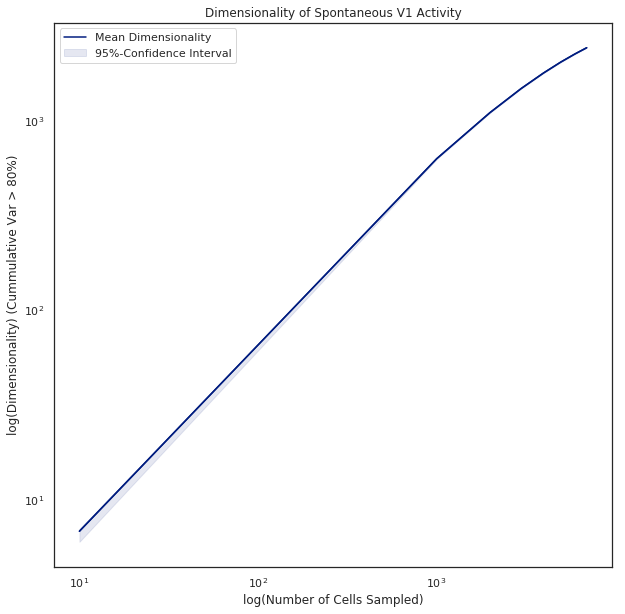

In [16]:
# Plot dimensionality means and confidence intervals
ax = plt.subplots(1,1,figsize=(10,10))[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(cell_sample_nums, dimensionality_means)
if pca_repetitions > 1:
    ax.fill_between(cell_sample_nums, (dimensionality_lower_ci), (dimensionality_upper_ci), color='b', alpha=.1, label='95%-Confidence Interval')
plt.plot(cell_sample_nums, dimensionality_means, color='b', label=f'Mean Dimensionality')
plt.xlabel('log(Number of Cells Sampled)')
plt.ylabel(f'log(Dimensionality) (Cummulative Var > {int(100*cum_var_cutoff)}%)')
plt.title('Dimensionality of Spontaneous V1 Activity')
plt.legend()
plt.show()
plt.close()